In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(rc={'figure.figsize':(20,9)})

# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [4]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
data_m = data.resample('M').mean()

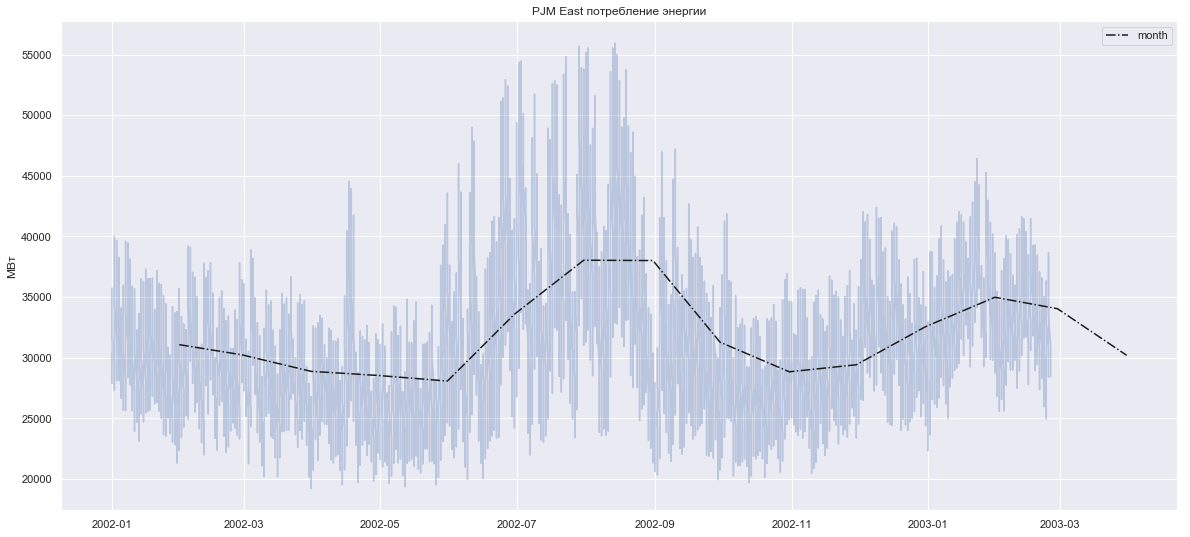

In [6]:
# plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

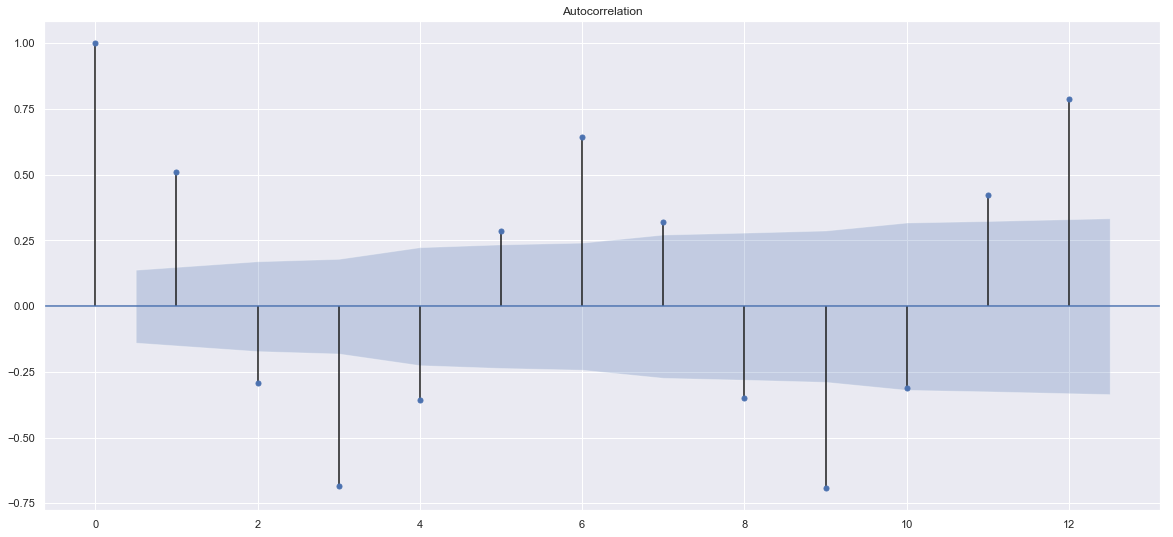

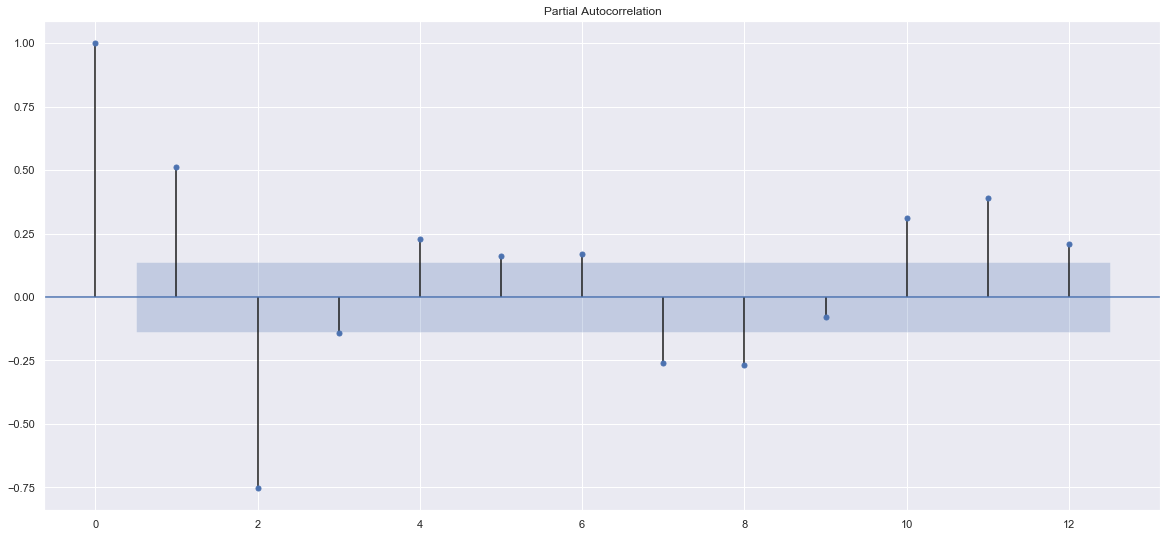

In [7]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=12)
plt.show()

2. Подберите параметры модели SARIMAX для этого ряда.

In [8]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,52] 

In [9]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 0, 52)
SARIMAX: (0, 0, 2) x (0, 0, 0, 52)
SARIMAX: (0, 0, 2) x (0, 0, 1, 52)


In [10]:
data_m['PJME_MW'].values.shape

(200,)

In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[300:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)3 - AIC:2.0
ARIMA(0, 0, 0)x(0, 1, 0, 52)3 - AIC:2.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)3 - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 0, 52)3 - AIC:2.0
ARIMA(0, 2, 0)x(0, 0, 0, 52)3 - AIC:2.0
ARIMA(0, 2, 0)x(0, 1, 0, 52)3 - AIC:2.0


In [12]:
N1 =20   # берем дданные не от начала - так быстрее работает
N2=12  # число точек для теста
nforecast = N2+3

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[0,0,1],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2306.9002369296613


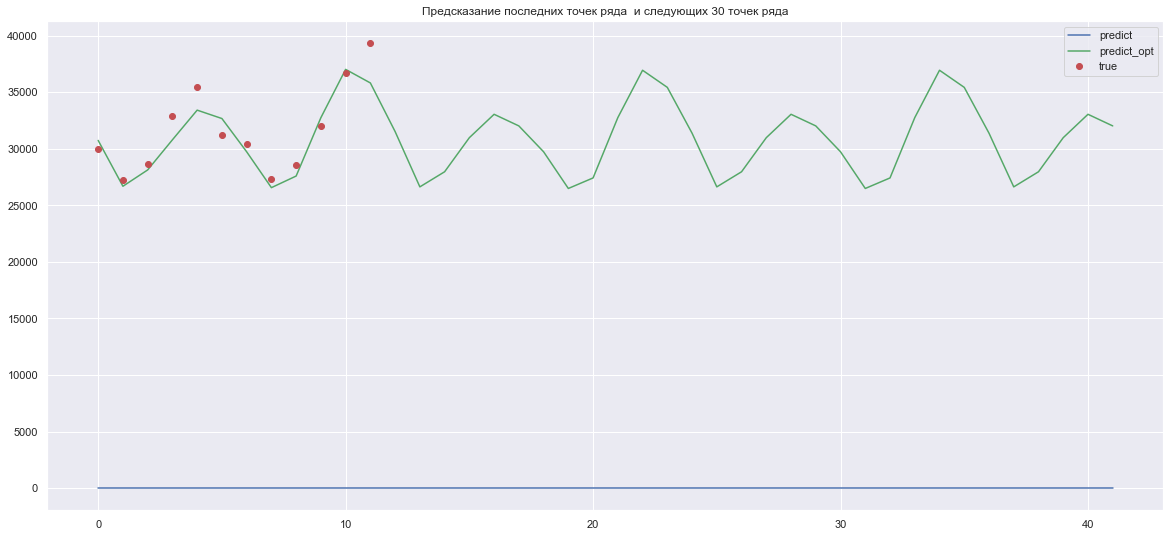

In [13]:
nforecast = N2+30  # полное число предиктов (тест+ чистый предикт)

pred_dynamic = results.forecast(nforecast)    #делаем предсказание на 30 точtк от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [14]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,0.4061,0.119,3.410,0.001,0.173,0.640
ma.S.L12,-0.6127,0.111,-5.507,0.000,-0.831,-0.395
ma.S.L24,0.1423,0.068,2.100,0.036,0.009,0.275
sigma2,3.727e+06,6.56e+05,5.684,0.000,2.44e+06,5.01e+06


***Результаты недельного сэмпла***

                coef  std err         	z 	    P>|z| 	[0.025 	  0.975]
ma.L1 	      0.3393 	0.061 	      5.570 	0.000 	0.220  	  0.459
ma.S.L52 	 -0.5225 	0.050 	     -10.366 	0.000 	-0.621   -0.424
ma.S.L104 	  0.0816 	0.035 	      2.349 	0.019 	0.014 	  0.150
sigma2 	   7.961e+06 	4.19e-10 	  1.9e+16 	0.000 	7.96e+06  7.96e+06

***Вывод***

Месячный сэмпл хуже недельного

4. Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )

In [15]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [16]:
data_w = brent_data.resample('W',).mean()

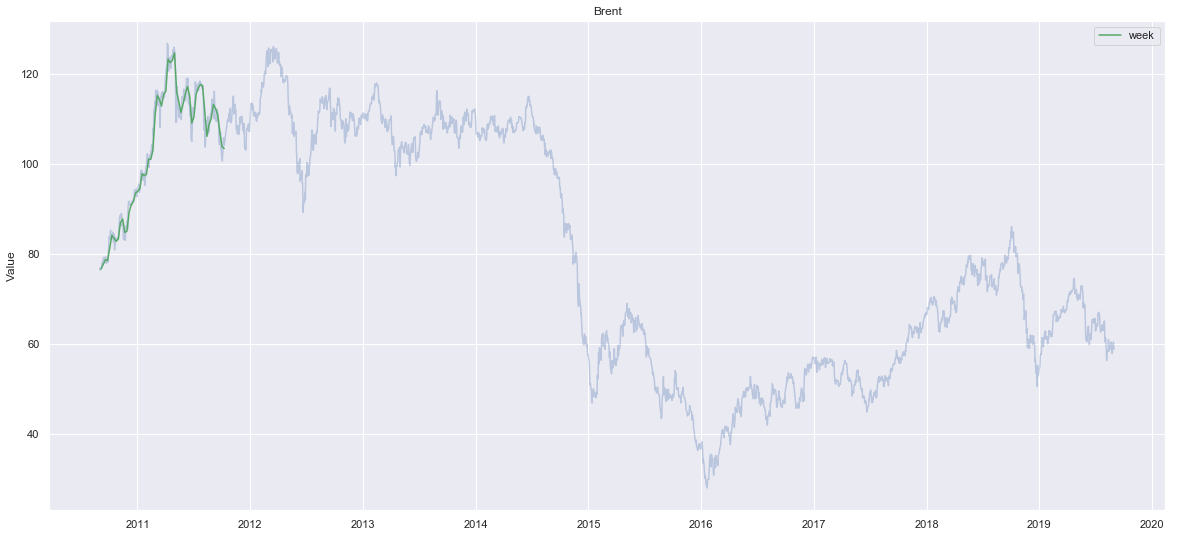

In [18]:
plt.plot( brent_data.index[:5*24*7*4*3], brent_data['Значение'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_w.index[:5*4*3], data_w['Значение'].values[:5*4*3], 'g',label='week'  )
plt.title('Brent' )
plt.ylabel ( 'Value' )
plt.legend()
plt.show()

In [57]:
data_w['Значение'].fillna(data_w['Значение'].mean(),inplace=True)
data_w.isnull().sum()

Значение           0
year               1
month              1
dayofmonth         1
quarter            1
dayofyear          1
weekofyear         1
dayofweek          1
is_holiday         1
is_prev_holiday    1
is_next_holiday    1
dtype: int64

In [71]:
data_w.shape

(470, 11)

486

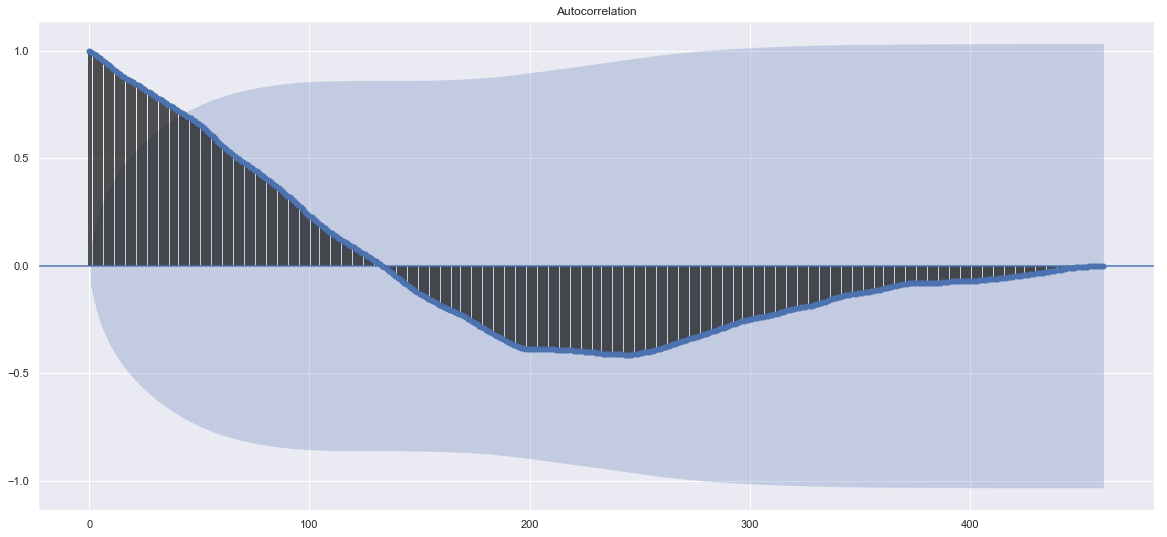

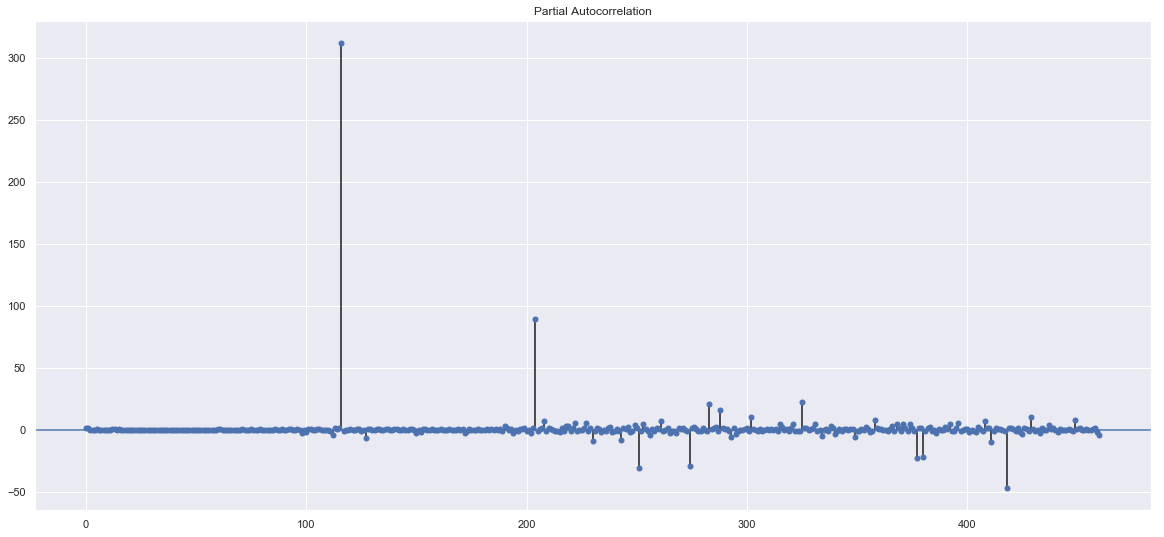

In [73]:
sm.graphics.tsa.plot_acf(data_w['Значение'].values, lags=460)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['Значение'].values, lags=460)
plt.show()

In [59]:
data_w_n=data_w['Значение'].values.tolist()

In [76]:

N=20    # число точек для теста
# строим модель
model = ARIMA(data_w_n[:-N], order=(1, 1,2))
model_fit = model.fit(disp=False)
# делаем оценку старых значений
y_p = model_fit.predict(len(data_w_n[:-N]), len(data_w_n[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_w[-10-N:],'r',label ='true')
plt.plot(y_p,'*b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_w_n')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

5. Оцените результат моделирования

Если это не ошибка, то ряд не станционарен и поэтому к нему не получается применить модель ARIMA

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

В целом для табличных данных хорошо подходит градиентный бустинг.